# Evaluation of CyteType

CyteType is a tool for automatic curation of cell types in single cell, using an LLM Annotator Agent.

In this notebook, I try the tool on a few datasets and compare it with other annotation tools.

### Install Libraries

In [31]:
!python -m pip install -q cytetype scanpy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\dallo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [32]:
import anndata
import scanpy as sc
import cytetype
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Initialize Paul15 dataset

The Paul et al 2015 dataset is a small single-cell dataset of myeloid cells, available from scanpy. The Cell types have been manually annotated, meaning we can compare cytetype's predictions against the true values.

In [33]:
#adata = sc.datasets.paul15()


In [53]:
import os
import scanpy as sc

if not os.path.exists("paul15_small.h5ad"):
    adata = sc.datasets.paul15()
    adata.write("paul15_small.h5ad")
else:
    adata = sc.read("paul15_small.h5ad")


### Process the data - compute clusters, etc

In [54]:
adata.obs["paul15_clusters"]

W31105      7MEP
W31106      15Mo
W31107      3Ery
W31108      15Mo
W31109      3Ery
           ...  
W39164      2Ery
W39165    13Baso
W39166      7MEP
W39167      15Mo
W39168      3Ery
Name: paul15_clusters, Length: 2730, dtype: category
Categories (19, object): ['1Ery', '2Ery', '3Ery', '4Ery', ..., '16Neu', '17Neu', '18Eos', '19Lymph']

In [56]:

# Load and preprocess your data
adata.var["gene_symbols"] = adata.var_names

# We compute the clusters as suggested by the tutorial
# However, this produces 10 clusters. We are going to use the 19 
# clusters from the original paper, which are stored in the `paul15_clusters` column.
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata) 
sc.tl.rank_genes_groups(adata, groupby='paul15_clusters', method='t-test')

# Initialize CyteType (performs data preparation)
annotator = cytetype.CyteType(adata, group_key='paul15_clusters')



Calculating expression percentages.
Extracting marker genes.
Data preparation completed. Ready for submitting jobs.


In [58]:
adata.obs

,paul15_clusters,leiden
W31105,7MEP,4
W31106,15Mo,5
W31107,3Ery,6
W31108,15Mo,5
W31109,3Ery,6
...,...,...
W39164,2Ery,0
W39165,13Baso,5
W39166,7MEP,4
W39167,15Mo,2


In [59]:
# How many clusters are there?
print(f"Number of clusters: {len(adata.obs['paul15_clusters'].unique())}")
adata.obs['paul15_clusters'].value_counts().sort_index()


Number of clusters: 19


paul15_clusters
1Ery        43
2Ery       329
3Ery       246
4Ery       124
5Ery       180
6Ery       173
7MEP       167
8Mk         68
9GMP        63
10GMP      153
11DC        30
12Baso      69
13Baso     300
14Mo       373
15Mo       186
16Neu      164
17Neu       22
18Eos        9
19Lymph     31
Name: count, dtype: int64

In [60]:
# Cluster annotation from original paper 
adata.obs


,paul15_clusters,leiden
W31105,7MEP,4
W31106,15Mo,5
W31107,3Ery,6
W31108,15Mo,5
W31109,3Ery,6
...,...,...
W39164,2Ery,0
W39165,13Baso,5
W39166,7MEP,4
W39167,15Mo,2


### Call the Agent! Run the annotation

In [ ]:
# Run annotation
adata = annotator.run(
    study_context="Mouse bone marrow cells undergoing myeloid differentiation"
)

# View results
#print(adata.obs.cytetype_leiden)

Waiting for results for job ID: 753cdc40-7312-41be-8358-fa09d8d7880d
View the automatically updating visualization report at: https://nygen-labs-prod--cell-annotation-agent-fastapi-app.modal.run/report/753cdc40-7312-41be-8358-fa09d8d7880d


### Compare annotation with existing one

The original annotation are more granular than the ones from Cytetype, so we manually create a dictionary to make a comparison.

In [39]:
print(adata.obs.cytetype_leiden)

W31105                                   
W31106    Granulocyte-Monocyte Progenitor
W31107                     Erythroid cell
W31108                         Neutrophil
W31109                     Erythroid cell
                       ...               
W39164                       Erythroblast
W39165                         Neutrophil
W39166                                   
W39167                         Neutrophil
W39168                     Erythroid cell
Name: cytetype_leiden, Length: 2730, dtype: category
Categories (8, object): ['', 'Dendritic cell', 'Erythroblast', 'Erythroid cell', 'Granulocyte-Monocyte Progenitor', 'Myeloid progenitor cell', 'NK cell', 'Neutrophil']


In [40]:
print(adata.obs.paul15_clusters)

W31105      7MEP
W31106      15Mo
W31107      3Ery
W31108      15Mo
W31109      3Ery
           ...  
W39164      2Ery
W39165    13Baso
W39166      7MEP
W39167      15Mo
W39168      3Ery
Name: paul15_clusters, Length: 2730, dtype: category
Categories (19, object): ['1Ery', '2Ery', '3Ery', '4Ery', ..., '16Neu', '17Neu', '18Eos', '19Lymph']


In [41]:
label_map = {
    '1Ery': 'Erythroid lineage cell',
    '2Ery': 'Erythroid lineage cell',
    '3Ery': 'Erythroid lineage cell',
    '4Ery': 'Erythroid lineage cell',
    '5MEP': 'Hematopoietic progenitor cell',
    '6MEP': 'Hematopoietic progenitor cell',
    '7MEP': 'Hematopoietic progenitor cell',
    '8GMP': 'Hematopoietic progenitor cell',
    '9DC': 'Hematopoietic progenitor cell',
    '10Baso': 'Hematopoietic progenitor cell',
    '11Mo': 'Hematopoietic progenitor cell',
    '12Mo': 'Hematopoietic progenitor cell',
    '13Baso': 'Hematopoietic progenitor cell',
    '14Mo': 'Hematopoietic progenitor cell',
    '15Mo': 'Hematopoietic progenitor cell',
    '16Neu': 'Neutrophil',
    '17Neu': 'Neutrophil',
    '18Eos': 'Hematopoietic progenitor cell',
    '19Lymph': 'Natural killer cell'  # could be NK/T-cell; best-effort match
}


In [42]:
adata.obs["true_broad"] = adata.obs["paul15_clusters"].map(label_map)

pd.crosstab(adata.obs["true_broad"], adata.obs["cytetype_leiden"], normalize='index')


cytetype_leiden,,Erythroblast,Erythroid cell,Granulocyte-Monocyte Progenitor,Myeloid progenitor cell,NK cell,Neutrophil
true_broad,,,,,,,
Erythroid lineage cell,0.017520,0.45283,0.529650,0.000000,0.000000,0.000000,0.000000
Hematopoietic progenitor cell,0.159420,0.00000,0.004831,0.287923,0.088889,0.000000,0.458937
Natural killer cell,0.032258,0.00000,0.000000,0.000000,0.000000,0.967742,0.000000
Neutrophil,0.048387,0.00000,0.000000,0.059140,0.069892,0.000000,0.822581


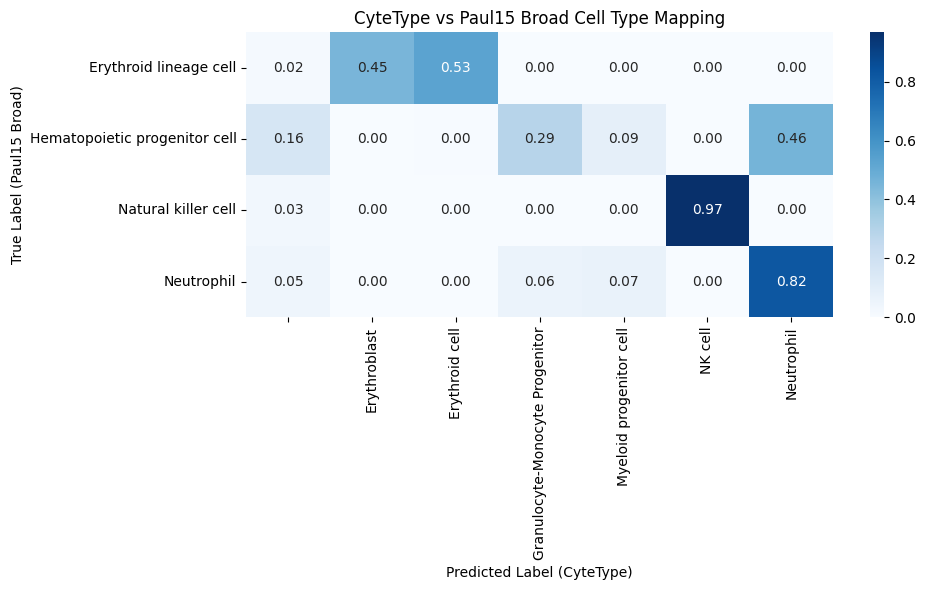

In [43]:
# Create normalized confusion matrix
conf_mat = pd.crosstab(
    adata.obs["true_broad"], 
    adata.obs["cytetype_leiden"], 
    normalize='index'
)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("CyteType vs Paul15 Broad Cell Type Mapping")
plt.ylabel("True Label (Paul15 Broad)")
plt.xlabel("Predicted Label (CyteType)")
plt.tight_layout()
plt.show()

## What if we give the wrong description?

Let's give a wrong instruction to CyteType, for example by saying that this is a retina dataset in Zebrafish, to see if it still returns good results

In [45]:
adata2 = annotator.run(
    study_context="Zebrafish retina development during embryogenesis"
)


Waiting for results for job ID: b65b1785-0a85-4541-bc40-8b065ba5d686
View the automatically updating visualization report at: https://nygen-labs-prod--cell-annotation-agent-fastapi-app.modal.run/report/b65b1785-0a85-4541-bc40-8b065ba5d686
250603:2051:06 |INFO| [STARTING WORKFLOWS]: Job ID: b65b1785-0a85-4541-bc40-8b065ba5d686
250603:2051:06 |INFO| [WORKFLOW STEP 1/3]: Generating context summary
250603:2051:22 |INFO| [WORKFLOW STEP 2/3]: Running cluster contextualization, annotation, review, and ontology assignment
250603:2051:25 |INFO| [Cluster: 1] Generating cluster-specific context...
250603:2051:27 |INFO| [Cluster: 10] Generating cluster-specific context...
250603:2051:30 |INFO| [Cluster: 2] Generating cluster-specific context...
250603:2051:32 |INFO| [Cluster: 3] Generating cluster-specific context...
250603:2051:35 |INFO| [Cluster: 4] Generating cluster-specific context...
250603:2051:41 |INFO| [Cluster: 1] Annotating cluster...
250603:2051:44 |INFO| [Cluster: 2] Annotating cluste

In [50]:
adata2.obs["true_broad"] = adata2.obs["paul15_clusters"].map(label_map)

pd.crosstab(adata2.obs["true_broad"], adata2.obs["cytetype_leiden"], normalize='index')


cytetype_leiden,,Erythroid cell,Myeloid cell,Neutrophil
true_broad,,,,
Erythroid lineage cell,0.017520,0.982480,0.000000,0.000000
Hematopoietic progenitor cell,0.447343,0.004831,0.088889,0.458937
Natural killer cell,1.000000,0.000000,0.000000,0.000000
Neutrophil,0.107527,0.000000,0.069892,0.822581


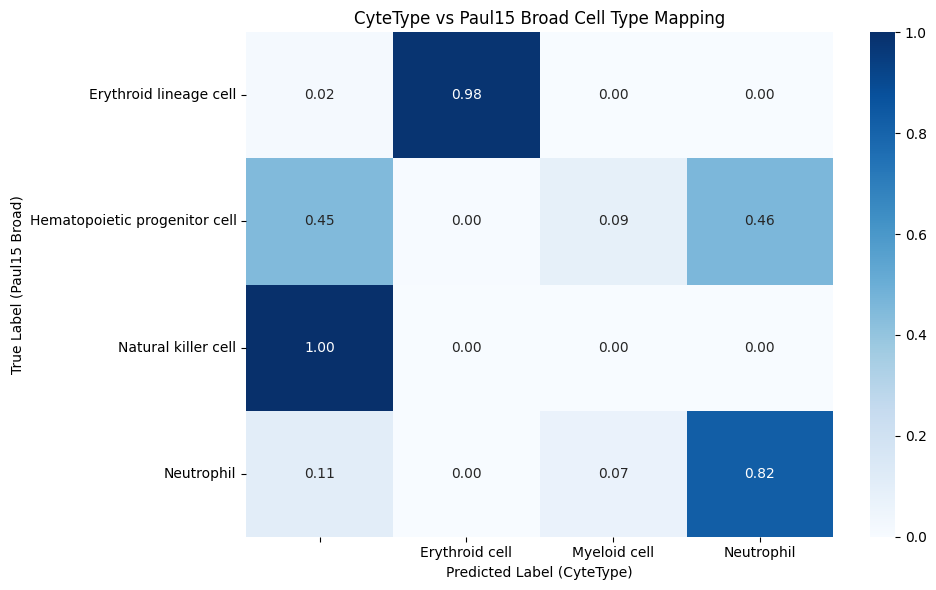

In [48]:
# Create normalized confusion matrix
conf_mat = pd.crosstab(
    adata2.obs["true_broad"], 
    adata2.obs["cytetype_leiden"], 
    normalize='index'
)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("CyteType vs Paul15 Broad Cell Type Mapping")
plt.ylabel("True Label (Paul15 Broad)")
plt.xlabel("Predicted Label (CyteType)")
plt.tight_layout()
plt.show()